<br>
</p>
<p align="left">
      <img src="oft.png" 
       width="400">
<br>

# Option Pricing with Cointegrated Assets 

### Notebook by [Marco Tavora](https://marcotavora.me/)

## Table of contents

1. [What is Pairs Trading?](#What-is-Pairs-Trading)
2. [Importing modules](#Importing-modules)
3. [Cointegrated ficticious stocks](#Cointegrated-ficticious-stocks)

## What is Pairs Trading?
[[go back to the top]](#Table-of-contents)

From [Wiki](https://en.wikipedia.org/wiki/Pairs_trade):
> Pair trading is a market neutral trading strategy enabling traders to profit from virtually any market conditions: uptrend, downtrend, or sideways movement. This strategy is categorized as a statistical arbitrage and convergence trading strategy.

Consider a pair of assets $y_{1,t}$ and $y_{2,t}$ historically correlated and having some kind of underlying economic link. For example, $y_{1,t}$ and $y_{2,t}$ could be Pepsi and Coca-Cola stocks.

> When the correlation between the two securities temporarily weakens, i.e. one stock moves up while the other moves down, the pairs trade would be to short the outperforming stock and to long the underperforming one, betting that the "spread" between the two would eventually converge. 

This deviation from equilibrium within a pair can be caused by:
> temporary supply/demand changes, large buy/sell orders for one security, reaction for important news about one of the companies, and so on. [...] Although the strategy does not have much downside risk, there is a scarcity of opportunities, and, for profiting, the trader must be one of the first to capitalize on the opportunity. A notable pairs trader was hedge fund Long-Term Capital Management.

### Quick review: Long and Short Position ([link](https://www.investopedia.com/terms/l/long.asp)):

> With a long position investment, the investor purchases an asset and owns it with the expectation that the price is going to rise. He normally has no plan to sell the security in the near future. A key component of long position investment is the ownership of the stock or bond. 

> This contrasts with the short position investment, where an investor does not own the stock but borrows it with the expectation of selling it and then repurchasing it at a lower price. 

From Hull's book (Fig.1):
<br>
</p>
<p align="left">
      <img src="short-selling.png" 
       width="700">
<br>

## Importing Python packages
[[go back to the top]](#Table-of-contents)

In [2]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
import seaborn as sns; sns.set()
from statsmodels.tsa.stattools import coint
np.random.seed(107)
import matplotlib.pyplot as plt
%matplotlib inline

## Cointegrated ficticious stocks
[[go back to the top]](#Table-of-contents)

Roughly speaking, two time series are cointegrated when there is some linear combination of them which varies around a mean. 

In [3]:
stocks = pd.read_csv('stocks.csv')
stocks.head()

,time,y1,y2
0,1,49.09,52.37
1,2,47.86,51.89
2,3,47.83,52.49
3,4,47.17,52.45
4,5,45.72,51.65


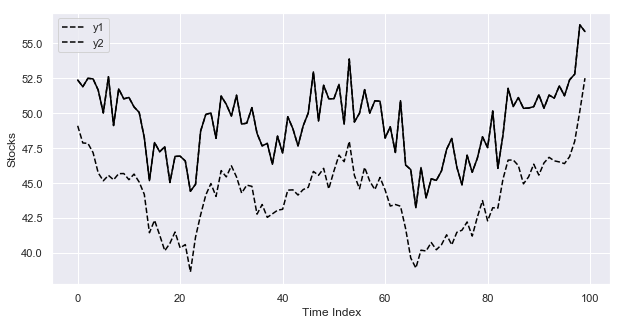

In [5]:
stocks.iloc[:, 1:].plot(figsize=(10,5), color='black',  linestyle='--');
plt.plot(stocks['y2'], color='black') 
plt.xlabel('Time Index')
plt.ylabel('Stocks')
plt.show();

## Cointegration tests
[[go back to the top]](#Table-of-contents)

The package `statsmodels` has a test of cointegration called `coint`. From the [docs](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html), `coint` is a:

> Test for no-cointegration of a univariate equation. The null hypothesis is no cointegration. Variables in y0 and y1 are assumed to be integrated of order 1, I(1). This uses the augmented Engle-Granger two-step cointegration test.

If we choose our confidence level to be $\alpha$ the $p$-value from the test should be below this cutoff.

In [6]:
p = 0.05
score, pvalue, _ = coint(stocks['y1'], 
                         stocks['y2'])

print('p-value is:', pvalue)

p-value is: 8.504226293690754e-16


#### Condition for cointegration

In [7]:
if pvalue < p:
    print('The series are cointegrated.')
else:
    print('No cointegration!')

The series are cointegrated.


## Correlation vs. Cointegration
[[go back to the top]](#Table-of-contents)

Note that correlation and cointegration have similarities but are different quantities. For example, these two - rather artificial - series, a normally distributed series and a square wave, are cointegrated with zero $p$-value but effectively uncorrelated. This is taken from [Quantopian](https://www.quantopian.com/posts).

Cointegration test p-value: 0.0
Correlation: -0.04130406958091657


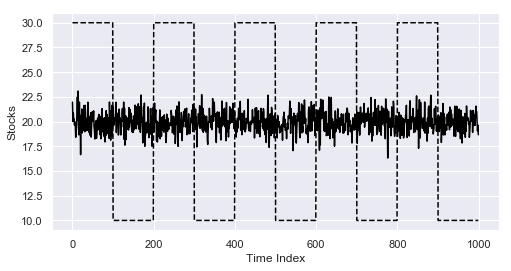

In [8]:
df = pd.read_csv('coint_vs_corr.csv', 
                 index_col=0)

df.columns = ['y1', 'y2']

score, pvalue, _ = coint(df['y1'], 
                         df['y2'])

print('Cointegration test p-value: ' + str(pvalue))
print('Correlation: ' + str(df['y1'].corr(df['y2'])))

df.iloc[:, 1].plot(figsize = (8,4), 
                   color = 'black', 
                   linestyle = '--');

plt.plot(df['y1'], 
         color='black') 

plt.xlabel('Time Index');
plt.ylabel('Stocks');
plt.show();

## Hedge 
[[go back to the top]](#Table-of-contents)

Short sales can be used to hedge long investments. Why?

- Short sale makes money if the asset sold loses value. In Fig.1 the short sale of $y_{1,t}$ made $\$20$ per share because the price went down by $\$20$
- Long purchase of $y_{1,t}$ will make money if asset increaes value
- One should long parts of the market and short others.

## General strategy
[[go back to the top]](#Table-of-contents)

Pairs trading maintains a hedged position across both assets $y_{1,t}$ and $y_{2,t}$. Possible scenarios:
- Both prices go down: we do not gain nor lose money
- If both go up, the same thing happens. 
- Our gains occur when the the spread of the two reverts to the mean. 
- We need to watch for when both stocks are far apart, short $y_{1,t}$ and long $y_{2,t}$ 
- We also watch for when they're close together, long $y_{2,t}$  and short $y_{1,t}$ .

## Code
[[go back to the top]](#Table-of-contents)

The code to find cointegrated pairs follows. Let us go over it step by step:

In [ ]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    list_keys = list(data.keys())
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[list_keys[i]]
            S2 = data[list_keys[j]]
            print(coint(S1, S2))
            score, pvalue, _  = coint(S1, S2)
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.02:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs
    return type(S1), S2
# keys = list(data.keys())
# keys[1]
find_cointegrated_pairs(data)

In [15]:
from backtester.dataSource.yahoo_data_source import YahooStockDataSource

In [44]:
from datetime import datetime
startDateStr = '2007/12/01'
endDateStr = '2017/12/01'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['SPY','AAPL','ADBE','SYMC','EBAY','MSFT','QCOM',
                 'HPQ','JNPR','AMD','IBM']

In [45]:
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')

Processing data for stock: SPY
Processing data for stock: AAPL
Processing data for stock: ADBE
Processing data for stock: SYMC
Processing data for stock: EBAY
Processing data for stock: MSFT
Processing data for stock: QCOM
Processing data for stock: HPQ
Processing data for stock: JNPR
Processing data for stock: AMD
Processing data for stock: IBM
20% done...
40% done...
60% done...
80% done...


In [95]:
data_close = ds.getBookDataByFeature()['adjClose']
data_close.head()

,SPY,AAPL,ADBE,SYMC,EBAY,MSFT,QCOM,HPQ,JNPR,AMD,IBM
2007-12-03,118.179031,22.645098,42.689999,12.552974,13.867846,25.335382,30.802353,15.650877,28.200424,9.66,79.256721
2007-12-04,117.122704,22.765379,43.320000,12.782257,13.859427,25.219950,30.339844,15.734653,28.237570,9.25,79.855850
2007-12-05,119.083336,23.485783,43.900002,12.825243,14.036196,26.282000,31.229469,16.029421,29.063990,8.91,81.001671
2007-12-06,120.787804,24.049175,44.540001,12.904058,14.212963,26.589848,31.260408,16.200075,29.017561,9.07,82.154961
2007-12-07,120.763748,24.599937,44.369999,12.689111,14.196128,26.574453,31.036068,16.085279,28.692566,9.05,81.525909


In [87]:
# find_cointegrated_pairs(data.all)

In [88]:
# def zscore(series):
#     return (series - series.mean()) / np.std(series)

In [89]:
# scores, pvalues, pairs = find_cointegrated_pairs(data)
# import seaborn
# m = [0,0.2,0.4,0.6,0.8,1]
# seaborn.heatmap(pvalues, xticklabels=instrumentIds, 
#                 yticklabels=instrumentIds, cmap='RdYlGn_r' 
#                 , mask = (pvalues >= 0.98)
#                 )
# plt.show()
# print pairs

In [90]:
# import operator
# import numpy as np
# import pandas as pd
# np.random.seed(0)
# df = pd.DataFrame(np.random.randn(5,3), columns=list('ABC'))
# data_close.loc[operator.or_(data_close.SPY > 0.25, df.SPY < -0.25)]


In [91]:
# scores, pvalues, pairs = find_cointegrated_pairs(data)
# import seaborn
# m = [0,0.2,0.4,0.6,0.8,1]
# seaborn.heatmap(pvalues, xticklabels=instrumentIds, 
#                 yticklabels=instrumentIds, cmap='RdYlGn_r', 
#                 mask = (pvalues >= 0.98))
# plt.show()
# print( pairs)

In [92]:
# S1 = data['ADBE']
# S2 = data['MSFT']
# score, pvalue, _ = coint(S1, S2)
# print(pvalue)
# ratios = S1 / S2
# ratios.plot()
# plt.axhline(ratios.mean())
# plt.legend([' Ratio'])
# plt.show()

In [ ]:
# ## Looking for Cointegrated Pairs of Alternative Energy Securities
# We are looking through a set of solar company stocks to see if any of them are cointegrated. We'll start by defining the list of securities we want to look through. Then we'll get the pricing data for each security for the year of 2014.

# Our approach here is somewhere in the middle of the spectrum that we mentioned before. We have formulated an economic hypothesis that there is some sort of link between a subset of securities within the energy sector and we want to test whether there are any cointegrated pairs. This incurs significantly less multiple comparisons bias than searching through hundreds of securities and slightly more than forming a hypothesis for an individual test.

# NOTE: We include the market in our data. This is because the market drives the movement of so many securities that you often times might find two seemingingly cointegrated securities, but in reality they are not cointegrated and just both conintegrated with the market. This is known as a confounding variable and it is important to check for market involvement in any relationship you find.

# get_pricing() is a Quantopian method that pulls in stock data, and loads it into a Python Pandas DataPanel object.  Available fields are 'price', 'open_price', 'high', 'low', 'volume'.  But for this example we will just use 'price' which is the daily closing price of the stock.

In [96]:
# symbol_list = ['ABGB', 'ASTI', 'CSUN', 'DQ', 'FSLR','SPY']
# prices_df = get_pricing(symbol_list, fields=['price']
#                                , start_date='2014-01-01', end_date='2015-01-01')['price']
# prices_df.columns = map(lambda x: x.symbol, prices_df.columns)

In [ ]:
# Example of how to get all the prices of all the stocks loaded using get_pricing() above in one pandas dataframe object

# prices_df.head()

# Example of how to get just the prices of a single stock that was loaded using get_pricing() above

# prices_df['SPY'].head()

# Now we'll run our method on the list and see if any pairs are cointegrated.

# # Heatmap to show the p-values of the cointegration test between each pair of
# # stocks. Only show the value in the upper-diagonal of the heatmap

# scores, pvalues, pairs = find_cointegrated_pairs(prices_df)
# import seaborn
# seaborn.heatmap(pvalues, xticklabels=symbol_list, yticklabels=symbol_list, cmap='RdYlGn_r' 
#                 , mask = (pvalues >= 0.05)
#                 )
# print pairs

# Looks like 'ABGB' and 'FSLR' are cointegrated. Let's take a look at the prices to make sure there's nothing weird going on.

# S1 = prices_df['ABGB']
# S2 = prices_df['FSLR']

# score, pvalue, _ = coint(S1, S2)
# pvalue

# ## Calculating the Spread
# Now we will plot the spread of the two series. In order to actually calculate the spread, we use a linear regression to get the coefficient for the linear combination to construct between our two securities, as shown in the [stationarity lecture](https://www.quantopian.com/lectures/integration-cointegration-and-stationarity). Using a linear regression to estimate the coefficient is known as the Engle-Granger method.

# S1 = sm.add_constant(S1)
# results = sm.OLS(S2, S1).fit()
# S1 = S1['ABGB']
# b = results.params['ABGB']

# spread = S2 - b * S1
# spread.plot()
# plt.axhline(spread.mean(), color='black')
# plt.legend(['Spread']);

# Alternatively, we could examine the ratio betwen the two series.

# ratio = S1/S2
# ratio.plot()
# plt.axhline(ratio.mean(), color='black')
# plt.legend(['Price Ratio']);

# Examining the price ratio of a trading pair is a traditional way to handle pairs trading. Part of why this works as a signal is based in our assumptions of how stock prices move, specifically because stock prices are typically assumed to be log-normally distributed. What this implies is that by taking a ratio of the prices, we are taking a linear combination of the returns associated with them (since prices are just the exponentiated returns).

# This can be a little irritating to deal with for our purposes as purchasing the precisely correct ratio of a trading pair may not be practical. We choose instead to move forward with simply calculating the spread between the cointegrated stocks using linear regression. This is a very simple way to handle the relationship, however, and is likely not feasible for non-toy examples. There are other potential methods for estimating the spread listed at the bottom of this lecture. If you want to get more into the theory of why having cointegrated stocks matters for pairs trading, again, please see the Integration, Cointegration, and Stationarity Lecture from the [Quantopian Lecture Series](https://www.quantopian.com/lectures#Integration,-Cointegration,-and-Stationarity).

# So, back to our example. The absolute spread isn't very useful in statistical terms. It is more helpful to normalize our signal by treating it as a z-score. 

# ### WARNING
# In practice this is usually done to try to give some scale to the data, but this assumes some underlying distribution, usually a normal distribution. Under a normal distribution, we would know that approximately 84% of all spread values will be smaller. However, much financial data is not normally distributed, and one must be very careful not to assume normality, nor any specific distribution when generating statistics. It could be the case that the true distribution of spreads was very fat-tailed and prone to extreme values. This could mess up our model and result in large losses.

# def zscore(series):
#     return (series - series.mean()) / np.std(series)

# zscore(spread).plot()
# plt.axhline(zscore(spread).mean(), color='black')
# plt.axhline(1.0, color='red', linestyle='--')
# plt.axhline(-1.0, color='green', linestyle='--')
# plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

# ### Simple Strategy:
# * Go "Long" the spread whenever the z-score is below -1.0
# * Go "Short" the spread when the z-score is above 1.0
# * Exit positions when the z-score approaches zero

# This is just the tip of the iceberg, and only a very simplistic example to illustrate the concepts.  In practice you would want to compute a more optimal weighting for how many shares to hold for S1 and S2.  Some additional resources on pair trading are listed at the end of this notebook

# ## Trading using constantly updating statistics
# In general taking a statistic over your whole sample size can be bad. For example, if the market is moving up, and both securities with it, then your average price over the last 3 years may not be representative of today. For this reason traders often use statistics that rely on rolling windows of the most recent data.

# ## Moving Averages
# A moving average is just an average over the last $n$ datapoints for each given time. It will be undefined for the first $n$ datapoints in our series. Shorter moving averages will be more jumpy and less reliable, but respond to new information quickly. Longer moving averages will be smoother, but take more time to incorporate new information.

# We also need to use a rolling beta, a rolling estimate of how our spread should be calculated, in order to keep all of our parameters up to date.

# # Get the spread between the 2 stocks
# # Calculate rolling beta coefficient
# rolling_beta = pd.ols(y=S1, x=S2, window_type='rolling', window=30)
# spread = S2 - rolling_beta.beta['x'] * S1
# spread.name = 'spread'

# # Get the 1 day moving average of the price spread
# spread_mavg1 = pd.rolling_mean(spread, window=1)
# spread_mavg1.name = 'spread 1d mavg'

# # Get the 30 day moving average
# spread_mavg30 = pd.rolling_mean(spread, window=30)
# spread_mavg30.name = 'spread 30d mavg'

# plt.plot(spread_mavg1.index, spread_mavg1.values)
# plt.plot(spread_mavg30.index, spread_mavg30.values)

# plt.legend(['1 Day Spread MAVG', '30 Day Spread MAVG'])

# plt.ylabel('Spread');

# We can use the moving averages to compute the z-score of the spread at each given time. This will tell us how extreme the spread is and whether it's a good idea to enter a position at this time. Let's take a look at the z-score now.

# # Take a rolling 30 day standard deviation
# std_30 = pd.rolling_std(spread, window=30)
# std_30.name = 'std 30d'

# # Compute the z score for each day
# zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30
# zscore_30_1.name = 'z-score'
# zscore_30_1.plot()
# plt.axhline(0, color='black')
# plt.axhline(1.0, color='red', linestyle='--');

# The z-score doesn't mean much out of context, let's plot it next to the prices to get an idea of what it looks like. We'll take the negative of the z-score because the spreads were all negative and that is a little counterintuitive to trade on.

# # Plot the prices scaled down along with the negative z-score
# # just divide the stock prices by 10 to make viewing it on the plot easier
# plt.plot(S1.index, S1.values/10)
# plt.plot(S2.index, S2.values/10)
# plt.plot(zscore_30_1.index, zscore_30_1.values)
# plt.legend(['S1 Price / 10', 'S2 Price / 10', 'Price Spread Rolling z-Score']);

# ## Out of Sample Test
# Now that we have constructed our spread appropriately and have an idea of how we will go about making trades, it is time to conduct some out of sample testing. Our whole model is based on the premise that these securities are cointegrated, but we built it on information from a certain time period. If we actually want to implement this model, we need to conduct an out of sample test to confirm that the principles of our model are still valid going forward.

# Since we initially built the model on the 2014 - 2015 year, let's see if this cointegrated relationship holds for 2015 - 2016. Historical results do not guarantee future results so this is a sanity check to see if the work we have done holds strong.

# symbol_list = ['ABGB', 'FSLR']
# prices_df = get_pricing(symbol_list, fields=['price']
#                                , start_date='2015-01-01', end_date='2016-01-01')['price']
# prices_df.columns = map(lambda x: x.symbol, prices_df.columns)

# S1 = prices_df['ABGB']
# S2 = prices_df['FSLR']

# score, pvalue, _ = coint(S1, S2)
# print 'p-value: ', pvalue

# Unfortunately, since our p-value is above the cutoff of $0.05$, we conclude that our model will no longer be valid due to the lack of cointegration between our chosen securities. If we tried to deploy this model without the underlying assumptions holding, we would have no reason to believe that it would actually work. Out of sample testing is a vital step to make sure that our work will actually be viable in the market.

# ## Implementation
# When actually implementing a pairs trading strategy you would normally want to be trading many different pairs at once. If you find a good pair relationship by analyzing data, there is no guarantee that that relationship will continue into the future. Trading many different pairs creates a diversified portfolio to mitigate the risk of individual pairs "falling out of" cointegration.

# There is a template [algorithm](https://www.quantopian.com/lectures/example-basic-pairs-trading-algorithm) attached to this lecture that shows an example of how you would implement pairs trading on our platform. Feel free to check it out and modify it with your own pairs to see if you can improve it.

# ## Further Research
# This notebook contained some simple introductory approaches. In practice one should use more sophisticated statistics, some of which are listed here.

# * Augmented-Dickey Fuller test 
# * Hurst exponent
# * Half-life of mean reversion inferred from an Ornstein–Uhlenbeck process
# * Kalman filters

# (this is *not* an endorsement) But, a very good practical resource for learning more about pair trading is Dr. Ernie Chan's book:  Algorithmic Trading: Winning Strategies and Their Rationale

# # # Pairs Trading with Machine Learning
# # Jonathan Larkin

# # August, 2017

# # In developing a Pairs Trading strategy, finding valid, eligible pairs which exhibit unconditional mean-reverting behavior is of critical importance. This notebook walks through an example implementation of finding eligible pairs. We show how popular algorithms from Machine Learning can help us navigate a very high-dimensional seach space to find tradeable pairs.

# # import matplotlib.pyplot as plt
# # import matplotlib.cm as cm

# # import numpy as np
# # import pandas as pd

# # from sklearn.cluster import KMeans, DBSCAN
# # from sklearn.decomposition import PCA
# # from sklearn.manifold import TSNE
# # from sklearn import preprocessing

# # from statsmodels.tsa.stattools import coint

# # from scipy import stats

# # from quantopian.pipeline.data import morningstar
# # from quantopian.pipeline.filters.morningstar import Q500US, Q1500US, Q3000US
# # from quantopian.pipeline import Pipeline
# # from quantopian.research import run_pipeline

# # print "Numpy: %s " % np.__version__
# # print "Pandas: %s " % pd.__version__

# # study_date = "2016-12-31"

# # ## Define Universe
# # We start by specifying that we will constrain our search for pairs to the a large and liquid single stock universe.

# # universe = Q1500US()

# # ## Choose Data
# # In addition to pricing, let's use some fundamental and industry classification data. When we look for pairs (or model anything in quantitative finance), it is generally good to have an "economic prior", as this helps mitigate overfitting. I often see Quantopian users create strategies with a fixed set of pairs that they have likely chosen by some fundamental rationale ("KO and PEP should be related becuase..."). A purely fundamental approach is a fine way to search for pairs, however breadth will likely be low. As discussed in [The Foundation of Algo Success](https://blog.quantopian.com/the-foundation-of-algo-success/), you can maximize Sharpe by having high breadth (high number of bets). With `N` stocks in the universe, there are `N*(N-1)/2` pair-wise relationships. However, if we do a brute-force search over these, we will likely end up with many spurious results. As such, let's narrow down the search space in a reasonable way. In this study, I start with the following priors:

# # - Stocks that share loadings to common factors (defined below) in the past should be related in the future.
# # - Stocks of similar market caps should be related in the future.
# # - We should exclude stocks in the industry group "Conglomerates" (industry code 31055). Morningstar analysts classify stocks into industry groups primarily based on similarity in revenue lines. "Conglomerates" is a catch-all industry. As described in the [Morningstar Global Equity
# # Classification Structure manual](http://corporate.morningstar.com/us/documents/methodologydocuments/methodologypapers/equityclassmethodology.pdf): "If the company has more than three sources of revenue and
# # income and there is no clear dominant revenue and income stream, the company
# # is assigned to the Conglomerates industry." We should not expect these stocks to be good members of any pairs in the future. This turns out to have zero impact on the Q500 and removes only 1 stock from the Q1500, but I left this idea in for didactic purposes.
# # - Creditworthiness in an important feature in future company performance. It's difficult to find credit spread data and map the reference entity to the appropriate equity security. There is a model, colloquially called the [Merton Model](http://www.investopedia.com/terms/m/mertonmodel.asp), however, which takes a contingent claims approach to modeling the capital structure of the firm. The output is an implied probability of default. Morningstar analysts calculate this for us and the field is called `financial_health_grade`. A full description of this field is in the [help docs](https://www.quantopian.com/help/fundamentals#asset-classification).

# # pipe = Pipeline(
# #     columns= {
# #         'Market Cap': morningstar.valuation.market_cap.latest.quantiles(5),
# #         'Industry': morningstar.asset_classification.morningstar_industry_group_code.latest,
# #         'Financial Health': morningstar.asset_classification.financial_health_grade.latest
# #     },
# #     screen=universe
# # )

# # res = run_pipeline(pipe, study_date, study_date)
# # res.index = res.index.droplevel(0)  # drop the single date from the multi-index

# # print res.shape
# # res.head()

# # # remove stocks in Industry "Conglomerates"
# # res = res[res['Industry']!=31055]
# # print res.shape

# # # remove stocks without a Financial Health grade
# # res = res[res['Financial Health']!= None]
# # print res.shape

# # # replace the categorical data with numerical scores per the docs
# # res['Financial Health'] = res['Financial Health'].astype('object')
# # health_dict = {u'A': 0.1,
# #                u'B': 0.3,
# #                u'C': 0.7,
# #                u'D': 0.9,
# #                u'F': 1.0}
# # res = res.replace({'Financial Health': health_dict})

# # res.describe()

# # ## Define Horizon
# # We are going to work with a daily return horizon in this strategy.

# # pricing = get_pricing(
# #     symbols=res.index,
# #     fields='close_price',
# #     start_date=pd.Timestamp(study_date) - pd.DateOffset(months=24),
# #     end_date=pd.Timestamp(study_date)
# # )

# # pricing.shape

# # returns = pricing.pct_change()

# # returns[symbols(['AAPL'])].plot();

# # # we can only work with stocks that have the full return series
# # returns = returns.iloc[1:,:].dropna(axis=1)

# # print returns.shape

# # ## Find Candidate Pairs
# # Given the pricing data and the fundamental and industry/sector data, we will first classify stocks into clusters and then, within clusters, looks for strong mean-reverting pair relationships.

# # The first hypothesis above is that "Stocks that share loadings to common factors in the past should be related in the future". Common factors are things like sector/industry membership and widely known ranking schemes like momentum and value. We could specify the common factors *a priori* to well known factors, or alternatively, we could let the data speak for itself. In this post we take the latter approach. We use PCA to reduce the dimensionality of the returns data and extract the historical latent common factor loadings for each stock. For a nice visual introduction to what PCA is doing, take a look [here](http://setosa.io/ev/principal-component-analysis/) (thanks to Gus Gordon for pointing out this site).

# # We will take these features, add in the fundamental features, and then use the `DBSCAN` **unsupervised** [clustering algorithm](http://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html#dbscan) which is available in [`scikit-learn`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). Thanks to Thomas Wiecki for pointing me to this specific clustering technique and helping with implementation. Initially I looked at using `KMeans` but `DBSCAN` has advantages in this use case, specifically

# # - `DBSCAN` does not cluster *all* stocks; it leaves out stocks which do not neatly fit into a cluster;
# # - relatedly, you do not need to specify the number of clusters.

# # The clustering algorithm will give us sensible *candidate* pairs. We will need to do some validation in the next step.

# # ### PCA Decomposition and DBSCAN Clustering

# # N_PRIN_COMPONENTS = 50
# # pca = PCA(n_components=N_PRIN_COMPONENTS)
# # pca.fit(returns)

# # pca.components_.T.shape

# # We have reduced data now with the first `N_PRIN_COMPONENTS` principal component loadings. Let's add some fundamental values as well to make the model more robust.

# # X = np.hstack(
# #     (pca.components_.T,
# #      res['Market Cap'][returns.columns].values[:, np.newaxis],
# #      res['Financial Health'][returns.columns].values[:, np.newaxis])
# # )

# # print X.shape

# # X = preprocessing.StandardScaler().fit_transform(X)
# # print X.shape

# # clf = DBSCAN(eps=1.9, min_samples=3)
# # print clf

# # clf.fit(X)
# # labels = clf.labels_
# # n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# # print "\nClusters discovered: %d" % n_clusters_

# # clustered = clf.labels_

# # # the initial dimensionality of the search was
# # ticker_count = len(returns.columns)
# # print "Total pairs possible in universe: %d " % (ticker_count*(ticker_count-1)/2)

# # clustered_series = pd.Series(index=returns.columns, data=clustered.flatten())
# # clustered_series_all = pd.Series(index=returns.columns, data=clustered.flatten())
# # clustered_series = clustered_series[clustered_series != -1]

# # CLUSTER_SIZE_LIMIT = 9999
# # counts = clustered_series.value_counts()
# # ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
# # print "Clusters formed: %d" % len(ticker_count_reduced)
# # print "Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum()

# # We have reduced the search space for pairs from >1mm to approximately 2,000.

# # ### Cluster Visualization
# # We have found 11 clusters. The data are clustered in 52 dimensions. As an attempt to visualize what has happened in 2d, we can try with [T-SNE](https://distill.pub/2016/misread-tsne/). T-SNE is an algorithm for visualizing very high dimension data in 2d, created in part by Geoff Hinton. We visualize the discovered pairs to help us gain confidence that the `DBSCAN` output is sensible; i.e., we want to see that T-SNE and DBSCAN both find our clusters.

# # X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)

# # plt.figure(1, facecolor='white')
# # plt.clf()
# # plt.axis('off')

# # plt.scatter(
# #     X_tsne[(labels!=-1), 0],
# #     X_tsne[(labels!=-1), 1],
# #     s=100,
# #     alpha=0.85,
# #     c=labels[labels!=-1],
# #     cmap=cm.Paired
# # )

# # plt.scatter(
# #     X_tsne[(clustered_series_all==-1).values, 0],
# #     X_tsne[(clustered_series_all==-1).values, 1],
# #     s=100,
# #     alpha=0.05
# # )

# # plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted');

# # We can also see how many stocks we found in each cluster and then visualize the normalized time series of the members of a handful of the smaller clusters.

# # plt.barh(
# #     xrange(len(clustered_series.value_counts())),
# #     clustered_series.value_counts()
# # )
# # plt.title('Cluster Member Counts')
# # plt.xlabel('Stocks in Cluster')
# # plt.ylabel('Cluster Number');

# # To again visualize if our clustering is doing anything sensible, let's look at a few clusters (for reproducibility, keep all random state and dates the same in this notebook).

# # # get the number of stocks in each cluster
# # counts = clustered_series.value_counts()

# # # let's visualize some clusters
# # cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

# # # plot a handful of the smallest clusters
# # for clust in cluster_vis_list[0:min(len(cluster_vis_list), 3)]:
# #     tickers = list(clustered_series[clustered_series==clust].index)
# #     means = np.log(pricing[tickers].mean())
# #     data = np.log(pricing[tickers]).sub(means)
# #     data.plot(title='Stock Time Series for Cluster %d' % clust)

# # We might be interested to see how a cluster looks for a particular stock. Large bank stocks share similar strict regulatory oversight and are similarly economic and interest rate sensitive. We indeed see that our clustering has found a bank stock cluster.

# # which_cluster = clustered_series.loc[symbols('JPM')]
# # clustered_series[clustered_series == which_cluster]

# # tickers = list(clustered_series[clustered_series==which_cluster].index)
# # means = np.log(pricing[tickers].mean())
# # data = np.log(pricing[tickers]).sub(means)
# # data.plot(legend=False, title="Stock Time Series for Cluster %d" % which_cluster);

# # Now that we have sensible clusters of common stocks, we can validate the cointegration relationships.

# # def find_cointegrated_pairs(data, significance=0.05):
# #     # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
# #     n = data.shape[1]
# #     score_matrix = np.zeros((n, n))
# #     pvalue_matrix = np.ones((n, n))
# #     keys = data.keys()
# #     pairs = []
# #     for i in range(n):
# #         for j in range(i+1, n):
# #             S1 = data[keys[i]]
# #             S2 = data[keys[j]]
# #             result = coint(S1, S2)
# #             score = result[0]
# #             pvalue = result[1]
# #             score_matrix[i, j] = score
# #             pvalue_matrix[i, j] = pvalue
# #             if pvalue < significance:
# #                 pairs.append((keys[i], keys[j]))
# #     return score_matrix, pvalue_matrix, pairs

# # cluster_dict = {}
# # for i, which_clust in enumerate(ticker_count_reduced.index):
# #     tickers = clustered_series[clustered_series == which_clust].index
# #     score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
# #         pricing[tickers]
# #     )
# #     cluster_dict[which_clust] = {}
# #     cluster_dict[which_clust]['score_matrix'] = score_matrix
# #     cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
# #     cluster_dict[which_clust]['pairs'] = pairs

# # pairs = []
# # for clust in cluster_dict.keys():
# #     pairs.extend(cluster_dict[clust]['pairs'])

# # pairs

# # print "We found %d pairs." % len(pairs)

# # print "In those pairs, there are %d unique tickers." % len(np.unique(pairs))

# # ### Pair Visualization
# # Lastly, for the pairs we found and validated, let's visualize them in 2d space with T-SNE again.

# # stocks = np.unique(pairs)
# # X_df = pd.DataFrame(index=returns.T.index, data=X)
# # in_pairs_series = clustered_series.loc[stocks]
# # stocks = list(np.unique(pairs))
# # X_pairs = X_df.loc[stocks]

# # X_tsne = TSNE(learning_rate=50, perplexity=3, random_state=1337).fit_transform(X_pairs)

# # plt.figure(1, facecolor='white')
# # plt.clf()
# # plt.axis('off')
# # for pair in pairs:
# #     ticker1 = pair[0].symbol
# #     loc1 = X_pairs.index.get_loc(pair[0])
# #     x1, y1 = X_tsne[loc1, :]

# #     ticker2 = pair[0].symbol
# #     loc2 = X_pairs.index.get_loc(pair[1])
# #     x2, y2 = X_tsne[loc2, :]
      
# #     plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray');
        
# # plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=[in_pairs_series.values], cmap=cm.Paired)
# # plt.title('T-SNE Visualization of Validated Pairs');


# # ## Conclusion and Next Steps

# # We have found a nice number of pairs to use in a pairs trading strategy. Note that the unique number of stocks is less than the number of pairs. This means that the same stock, e.g., AEP, is in more than one pair. This is fine, but we will need to take some special precautions in the **Portfolio Construction** stage to avoid excessive concentration in any one stock. Happy hunting for pairs!

# # *This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*

### Emails:

[Marcus Cabral](mailto:madriao@gmail.com)  

[Pedro Ferreira](mailto:pedrofer@openlink.com.br) 

[Marco Tavora](mailto:marcotav65@gmail.com)